# YOU_a2 (v1.0)

In [ ]:
# Standard imports
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import importlib
import time

# Q1: Logistic Function

Your answer here (double-click).

To help you with $\LaTeX$, and to show you my expectations, here is a sample taken from the lecture notes, taken from the 3rd and 4th page of the notes entitled "Error Backpropagation". It has nothing to do with the solution to this question, but just demonstrates some of the features of $\LaTeX$. Notice how I include English statments to guide the reader through the derivation.

<a target=_new href="http://detexify.kirelabs.org/classify.html">This web page</a> is very handy for identifying $\LaTeX$ symbols.

---
More generally, for $\vec{x} \in \mathbb{R}^X$, $\vec{h} \in \mathbb{R}^H$, and $\vec{y} \in \mathbb{R}^Y$.
$$
\begin{align}
\frac{\partial E}{\partial \alpha_i}
  &= \frac{d h_i}{d \alpha_i} \\
  &= \frac{d h_i}{d \alpha_i}
  \left[ M_{1i} \ \cdots \ M_{Yi} \right] \cdot
  \left[ \frac{\partial E}{\partial \beta_1} \ \cdots \ \frac{\partial E}{\partial \beta_Y} \right] \\
  &= \frac{d h_i}{d \alpha_i}
   \left[ M_{1i} \ \cdots \ M_{Yi} \right]
   \left[ \begin{array}{c}
     \frac{\partial E}{\partial \beta_1} \\
     \vdots \\
     \frac{\partial E}{\partial \beta_Y} \end{array} \right]
\end{align}
$$
Thus, for all elements,
$$
\begin{align}
\left[ \begin{array}{c}
  \frac{\partial E}{\partial \alpha_1} \\
  \vdots \\
  \frac{\partial E}{\partial \alpha_H}
\end{array} \right] &=
%
\left[ \begin{array}{c}
  \frac{d h_1}{d \alpha_1} \\
  \vdots \\
  \frac{d h_H}{d \alpha_H}
\end{array} \right]
\odot
\left[ \begin{array}{ccc}
  M_{11} & \cdots & M_{Y1} \\
  \vdots & \ddots & \vdots \\
  M_{1H} & \cdots & M_{YH}
\end{array} \right]
%
\left[ \begin{array}{c}
  \frac{\partial E}{\partial \beta_1} \\
  \vdots \\
  \frac{\partial E}{\partial \beta_Y}
\end{array} \right] \\
%
\frac{\partial E}{\partial \vec{\alpha}} &=
\frac{d \vec{h}}{d \vec{\alpha}} \odot M^\mathrm{T}
\frac{\partial E}{\partial \vec{\beta}}
\end{align}
$$



# Q2: Softmax

Your answer here.

# Q3: Top-Layer Error Gradients

Your answer here.

# Q4: Implementing Backprop

## Supplied Helper Functions

In [ ]:
# Supplied functions

def NSamples(x):
    '''
        n = NSamples(x)
        
        Returns the number of samples in a batch of inputs.
        
        Input:
         x   is a 2D array
        
        Output:
         n   is an integer
    '''
    return len(x)

def Shuffle(inputs, targets):
    '''
        s_inputs, s_targets = Shuffle(inputs, targets)
        
        Randomly shuffles the dataset.
        
        Inputs:
         inputs     array of inputs
         targets    array of corresponding targets
         
        Outputs:
         s_inputs   shuffled array of inputs
         s_targets  corresponding shuffled array of targets
    '''
    data = list(zip(inputs,targets))
    np.random.shuffle(data)
    s_inputs, s_targets = zip(*data)
    return np.array(s_inputs), np.array(s_targets)

def Logistic(z):
    '''
        y = Logistic(z)

        Applies the logistic function to each element in z.

        Input:
         z    is a scalar, list or array

        Output:
         y    is the same shape as z
    '''
    return 1. / (1 + np.exp(-z) )

def Logistic_p(h):
    '''
        yp = Logistic_p(h)
        
        Returns the slope of the logistic function at z when h = Logistic(z).
        Note the h is the input, NOT z.
    '''
    return h*(1.-h)

def Identity(z):
    '''
        y = Identity(z)

        Does nothing... simply returns z.

        Input:
         z    is a scalar, list or array

        Output:
         y    is the same shape as z
    '''
    return z

def Identity_p(h):
    '''
        yp = Identity_p(h)
        
        Returns the slope of the identity function h.
    '''
    return np.ones_like(h)

def OneHot(z):
    '''
        y = OneHot(z)

        Applies the one-hot function to the vectors in z.
        Example:
          OneHot([[0.9, 0.1], [-0.5, 0.1]])
          returns np.array([[1,0],[0,1]])

        Input:
         z    is a 2D array of samples

        Output:
         y    is an array the same shape as z
    '''
    y = []
    # Locate the max of each row
    for zz in z:
        idx = np.argmax(zz)
        b = np.zeros_like(zz)
        b[idx] = 1.
        y.append(b)
    y = np.array(y)
    return y

## Layer Class

In [ ]:
class Layer():
    
    def __init__(self, n_nodes, act='logistic'):
        '''
            lyr = Layer(n_nodes, act='logistic')
            
            Creates a layer object.
            
            Inputs:
             n_nodes  the number of nodes in the layer
             act      specifies the activation function
                      Use 'logistic' or 'identity'
        '''
        self.N = n_nodes  # number of nodes in this layer
        self.h = []       # node activities
        self.b = np.zeros(self.N)  # biases
        
        # Activation functions
        self.sigma = Logistic
        self.sigma_p = (lambda : Logistic_p(self.h))
        if act=='identity':
            self.sigma = Identity
            self.sigma_p = (lambda : Identity_p(self.h))

## Network Class

In [960]:
class Network():

    def __init__(self, sizes, type='classifier'):
        '''
            net = Network(sizes, type='classifier')

            Creates a Network and saves it in the variable 'net'.

            Inputs:
              sizes is a list of integers specifying the number
                  of nodes in each layer
                  eg. [5, 20, 3] will create a 3-layer network
                      with 5 input, 20 hidden, and 3 output nodes
              type can be either 'classifier' or 'regression', and
                  sets the activation function on the output layer,
                  as well as the loss function.
                  'classifier': logistic, cross entropy
                  'regression': linear, mean squared error
        '''
        self.n_layers = len(sizes)
        self.lyr = []    # a list of Layers
        self.W = []      # Weight matrices, indexed by the layer below it
        
        # Two common types of networks
        # The member variable self.Loss refers to one of the implemented
        # loss functions: MSE, or CrossEntropy.
        # Call it using self.Loss(t)
        if type=='classifier':
            self.classifier = True
            self.Loss = self.CrossEntropy
            activation = 'logistic'
        else:
            self.classifier = False
            self.Loss = self.MSE
            activation = 'identity'

        # Create and add Layers (using logistic for hidden layers)
        for n in sizes[:-1]:
            self.lyr.append( Layer(n) )
   
        # For the top layer, we use the appropriate activtaion function
        self.lyr.append( Layer(sizes[-1], act=activation) )
    
        # Randomly initialize weight matrices
        for idx in range(self.n_layers-1):
            m = self.lyr[idx].N
            n = self.lyr[idx+1].N
            temp = np.random.normal(size=[m,n])/np.sqrt(m)
            self.W.append(temp)


    def FeedForward(self, x):
        '''
            y = net.FeedForward(x)

            Runs the network forward, starting with x as input.
            Returns the activity of the output layer.
        '''
        x = np.array(x)  # Convert input to array, in case it's not
        
        # TODO: Check the code for biases.
        
        # layer.h will be of the shape : [num_samples, num_nodes]
        for i in range(len(self.lyr)):
            if i == 0:
                self.lyr[i].h = x
            else:
                last_layer_output = self.lyr[i-1].h
                linear = np.dot(last_layer_output, self.W[i-1])
                linear += np.outer(np.ones(len(x)), self.lyr[i].b)
                self.lyr[i].h = self.lyr[i].sigma(linear)
                
        
        return self.lyr[-1].h

    
    def Evaluate(self, inputs, targets):
        '''
            E = net.Evaluate(data)

            Computes the average loss over the supplied dataset.

            Inputs
             inputs  is an array of inputs
             targets is a list of corresponding targets

            Outputs
             E is a scalar, the average loss
        '''
        y = self.FeedForward(inputs)
        return self.Loss(targets)

    def ClassificationAccuracy(self, inputs, targets):
        '''
            a = net.ClassificationAccuracy(data)
            
            Returns the fraction (between 0 and 1) of correct one-hot classifications
            in the dataset.
        '''
        y = self.FeedForward(inputs)
        yb = OneHot(y)
        n_incorrect = np.sum(yb!=targets) / 2.
        return 1. - float(n_incorrect) / NSamples(inputs)

    
    def CrossEntropy(self, t):
        '''
            E = net.CrossEntropy(t)

            Evaluates the mean cross entropy loss between t and the activity of the top layer.
            To evaluate the network's performance on an input/output pair (x,t), use
              net.FeedForward(x)
              E = net.Loss(t)

            Inputs:
              t is an array holding the target output

            Outputs:
              E is the loss function for the given case
        '''
        
        #===== YOUR CODE HERE =====
        output_activity = self.lyr[-1].h # shape = (num_samples, num_outputs)
        #shape of t: (num_samples, num_outputs)
        
        # Equation for Cross Entropy (or negative log likelihood for observing the data given the parameters)
        # - (ylog(y) + (1-y)log(1-p))
        # Take the mean
        result = 0
        for i in range(len(t)):
            for j in range(5):
                if t[i][j] == 1:
                        result += np.log(output_activity[i][j])
                else:
                        result += np.log(1.-output_activity[i][j])
        return (-1*result)/len(t)

    
    def MSE(self, t):
        '''
            E = net.MSE(t)

            Evaluates the MSE loss function using t and the activity of the top layer.
            To evaluate the network's performance on an input/output pair (x,t), use
              net.FeedForward(x)
              E = net.Loss(t)

            Inputs:
              t is an array holding the target output

            Outputs:
              E is the loss function for the given case
        '''
        
        output_activity = self.lyr[-1].h
        error = np.mean(np.square(output_activity - t))
        
        return error

    
    def BackProp(self, t, lrate=0.05):
        '''
            net.BackProp(targets, lrate=0.05)
            
            Given the current network state and targets t, updates the connection
            weights and biases using the backpropagation algorithm.
            
            Inputs:
             t      an array of targets (number of samples must match the
                    network's output)
             lrate  learning rate
        '''
        t = np.array(t)  # convert t to an array, in case it's not
        
        # We are following (i-1) -> i at index i
        for i in range(len(self.lyr)-1,0,-1):
            if i == len(self.lyr)-1:
                de_dz = (self.lyr[-1].h - t).T # The gradient w.r.t. to the outermost layer: Y x P
            else:
                dh_dz = Logistic_p(self.lyr[i].h).T # This is H x P
                # W[i] is H x Y, de_dz is Y x P
                de_dz = np.multiply(dh_dz, np.dot(self.W[i], de_dz)) # This will be H x P
                
            # lyr[i-1].h is P x H, de_dz is Y x P or H(i+1) x P
            de_dw = np.dot(de_dz, self.lyr[i-1].h).T # To simplify : This will be H x Y
            de_dw /= t.shape[0]
            
            de_db = np.sum(de_dz, axis=1)/t.shape[0] # Length : Y
            self.lyr[i].b -= de_db
            
            self.W[i-1] -= lrate*de_dw

        

    def Learn(self, inputs, targets, lrate=0.05, epochs=1):
        '''
            Network.Learn(inputs, targets, lrate=0.05, epochs=1)

            Run through the dataset 'epochs' number of times, incrementing the
            network weights for each training sample. For each epoch, it
            shuffles the order of the samples.

            Inputs:
              inputs  is an array of input samples
              targets is a corresponding array of targets
              lrate   is the learning rate (try 0.001 to 0.5)
              epochs  is the number of times to go through the training data
        '''
        
        for i in range(epochs):
            train_inputs, train_targets = Shuffle(inputs, targets)
            y = self.FeedForward(train_inputs)
            self.BackProp(train_targets, lrate)


# Classification

## Create a Classification Dataset

In [961]:
# 5 Classes in 8-Dimensional Space
np.random.seed(15)
noise = 0.1
InputClasses = np.array([[1,0,1,0,0,1,1,0],
                         [0,1,0,1,0,1,0,1],
                         [0,1,1,0,1,0,0,1],
                         [1,0,0,0,1,0,1,1],
                         [1,0,0,1,0,1,0,1]], dtype=float)
OutputClasses = np.array([[1,0,0,0,0],
                          [0,1,0,0,0],
                          [0,0,1,0,0],
                          [0,0,0,1,0],
                          [0,0,0,0,1]], dtype=float)
n_input = np.shape(InputClasses)[1]
n_output = np.shape(OutputClasses)[1]
n_classes = np.shape(InputClasses)[0]

# Create a training dataset
n_samples = 100
training_output = []
training_input = []
for idx in range(n_samples):
    k = np.random.randint(n_classes)
    x = InputClasses[k,:] + np.random.normal(size=n_input)*noise
    t = OutputClasses[k,:]
    training_input.append(x)
    training_output.append(t)

# Create a test dataset
n_samples = 100
test_output = []
test_input = []
for idx in range(n_samples):
    k = np.random.randint(n_classes)
    x = InputClasses[k,:] + np.random.normal(size=n_input)*noise
    t = OutputClasses[k,:]
    test_input.append(x)
    test_output.append(t)

train = [np.array(training_input), np.array(training_output)]
test = [np.array(test_input), np.array(test_output)]

## Neural Network Model

In [1029]:
# Create a Network
net = Network([n_input, 18, n_output], type='classifier')

In [1030]:
# Evaluate it before training
CE = net.Evaluate(train[0], train[1])
accuracy = net.ClassificationAccuracy(train[0], train[1])
print('Cross Entropy = '+str(CE))
print('     Accuracy = '+str(accuracy*100.)+'%')

Cross Entropy = 3.814673463367807
     Accuracy = 16.000000000000004%


In [1031]:
net.Learn(train[0], train[1], epochs=500, lrate=1.)

## Evaluate it After Training

In [1032]:
print('Training Set')
CE = net.Evaluate(train[0], train[1])
accuracy = net.ClassificationAccuracy(train[0], train[1])
print('Cross Entropy = '+str(CE))
print('     Accuracy = '+str(accuracy*100.)+'%')
print('Test Set')
CE = net.Evaluate(test[0], test[1])
accuracy = net.ClassificationAccuracy(test[0], test[1])
print('Cross Entropy = '+str(CE))
print('     Accuracy = '+str(accuracy*100.)+'%')

Training Set
Cross Entropy = 0.018647677273450534
     Accuracy = 100.0%
Test Set
Cross Entropy = 0.019951973518195172
     Accuracy = 100.0%


## You can also try using the solutions

In [949]:
import Network_solutions as sol
net2 = sol.Network([n_input, 18, n_output], type='classifier')

In [950]:
net2.Learn(train[0], train[1], epochs=500, lrate=1.)
print('Training Set')
CE = net2.Evaluate(train[0], train[1])
accuracy = net2.ClassificationAccuracy(train[0], train[1])
print('Cross Entropy = '+str(CE))
print('     Accuracy = '+str(accuracy*100.)+'%')
print('Test Set')
CE = net2.Evaluate(test[0], test[1])
accuracy = net2.ClassificationAccuracy(test[0], test[1])
print('Cross Entropy = '+str(CE))
print('     Accuracy = '+str(accuracy*100.)+'%')

Training Set
Cross Entropy = 0.8874576713656723
     Accuracy = 96.0%
Test Set
Cross Entropy = 0.9454835621238553
     Accuracy = 92.0%


# Regression

## Create a Regression Dataset

In [951]:
# 1D -> 1D (linear mapping)
np.random.seed(846)
n_input = 1
n_output = 1
slope = np.random.rand() - 0.5
intercept = np.random.rand()*2. - 1.

def myfunc(x):
    return slope*x+intercept

# Create a training dataset
n_samples = 200
training_output = []
training_input = []
xv = np.linspace(-1, 1, n_samples)
for idx in range(n_samples):
    #x = np.random.rand()*2. - 1.
    x = xv[idx]
    t = myfunc(x) + np.random.normal(scale=0.1)
    training_input.append(np.array([x]))
    training_output.append(np.array([t]))

# Create a testing dataset
n_samples = 50
test_input = []
test_output = []
xv = np.linspace(-1, 1, n_samples)
for idx in range(n_samples):
    #x = np.random.rand()*2. - 1.
    x = xv[idx] + np.random.normal(scale=0.1)
    t = myfunc(x) + np.random.normal(scale=0.1)
    test_input.append(np.array([x]))
    test_output.append(np.array([t]))

# Create a perfect dataset
n_samples = 100
perfect_input = []
perfect_output = []
xv = np.linspace(-1, 1, n_samples)
for idx in range(n_samples):
    #x = np.random.rand()*2. - 1.
    x = xv[idx]
    t = myfunc(x)
    perfect_input.append(np.array([x]))
    perfect_output.append(np.array([t]))
    
train = [np.array(training_input), np.array(training_output)]
test = [np.array(test_input), np.array(test_output)]
perfect = [np.array(perfect_input), np.array(perfect_output)]

## Neural Network Model

In [952]:
net = Network([1, 10, 1], type='regression')

In [953]:
# Evaluate it before training
mse = net.Evaluate(train[0], train[1])
print('MSE = '+str(mse))

MSE = 0.35753196157541495


## Training

In [954]:
import Network_solutions as sol
net2 = sol.Network([1, 10, 1], type='regression')
import copy
net2.W = copy.deepcopy(net.W)
mse = net2.Evaluate(train[0], train[1])
print('MSE = '+str(mse))
net2.Learn(train[0], train[1], epochs=300)
mse = net2.Evaluate(train[0], train[1])
print('Training MSE = '+str(mse))
mse = net2.Evaluate(test[0], test[1])
print('Test MSE = '+str(mse))

MSE = 0.35753196157541495
Training MSE = 0.01413005011787162
Test MSE = 0.017301624623795225


In [955]:
net.Learn(train[0], train[1], epochs=300)

## Evaluate it After Training

In [956]:
# On training dataset
mse = net.Evaluate(train[0], train[1])
print('Training MSE = '+str(mse))

Training MSE = 0.014213040554918345


In [957]:
# On test dataset
mse = net.Evaluate(test[0], test[1])
print('Test MSE = '+str(mse))

Test MSE = 0.017381626953970906


In [958]:
# Evaluate our model and the TRUE solution (since we know it)
s = np.linspace(-1, 1, 200)
y = net.FeedForward(np.array([s]).T)
p = [myfunc(x) for x in s]

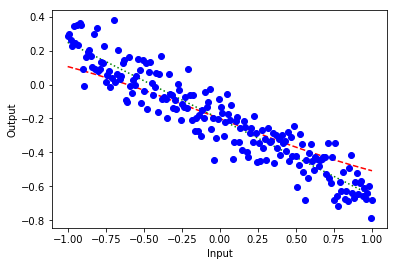

In [959]:
# Plot the training data,
# as well as out model and the true model
plt.plot(s,y, 'r--')
plt.plot(s,p, 'g:')
plt.plot(training_input, training_output, 'bo')
plt.xlabel('Input')
plt.ylabel('Output');